# Thesis Diagrams
This notebook is to generate all code / plots for the thesis document

In [42]:
# Imports
# Imports
import os, sys
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List
from sklearn.pipeline import Pipeline

# to enable local imports
module_path = os.path.abspath('code')
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")    
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
from data import onlineEegDataDict as subjectDict
from pipelines import filter_signal, prepare_signal, feature_extraction, convert_data
from machine_learning_data_generation import loadOnlineEEGdata, loadPickeldData
from utils import readFileCSV, loadConfigFile
from Transfomer_Signal import (BandpassFilter, BandstopFilter, ReplaceOutliers,
                                CenterData, ResampleSignal)

D:\Masterthesis\thesis_eeg\code


### Load Online EEG Data

In [33]:
# load the machine learning dataset
eegData, freqData = loadOnlineEEGdata(splitData=False)
eegX, eegy = eegData
freqX, freqy = freqData

# load one subject eeg data
epochSeries_1_normal, freqDf_1_normal = loadPickeldData("../EEG_Data/eeg_data_online/1", label="normal")
epochSeries_1_fatigue, freqDf_1_fatigue = loadPickeldData("../EEG_Data/eeg_data_online/1", label="fatigue")

# load one subject raw eeg data
eeg_1_raw_normal = readFileCSV("../EEG_Data/eeg_data_online/1/Fatigue_state_256hz.csv")
eeg_1_raw_fatigue = readFileCSV("../EEG_Data/eeg_data_online/1/Normal_state_256hz.csv")

Loading Online EEG Data from D:/Masterthesis/EEG_Data/eeg_data_online ...
Data does not get splitted into train and test!
EEG Data Shape:
(7178, 512, 40) (7178,)
Freq Data Shape:
(1440, 1, 1200) (1440,)


In [3]:
eeg_1_raw_normal.head()

,Unnamed: 0,HEOL,HEOR,FP1,FP2,VEOU,VEOL,F7,F3,FZ,...,P4,T6,A2,O1,OZ,O2,FT9,FT10,PO1,PO2
0,0,-15574.695876,0.0,-13934.266968,-22537.518691,-10631.029608,-840.036451,-11862.592118,-18548.862444,-19209.483980,...,-27398.899233,-19067.844301,0.0,-13417.704607,-18705.164048,-17777.848884,0.0,0.0,0.0,0.0
1,1,-15743.664639,0.0,-13953.251383,-22609.359742,-10690.129750,-877.975616,-11926.802881,-18489.937599,-19219.647004,...,-27539.160885,-19088.674625,0.0,-13514.279107,-18794.329177,-17799.327512,0.0,0.0,0.0,0.0
2,2,-15688.429098,0.0,-13977.308838,-22548.232769,-10673.391379,-872.475753,-11873.497830,-18495.901784,-19210.996257,...,-27498.309582,-19088.783090,0.0,-13445.249878,-18767.288611,-17793.187121,0.0,0.0,0.0,0.0
3,3,-15724.359000,0.0,-13959.228522,-22604.611647,-10675.307080,-886.191413,-11909.176903,-18510.074460,-19232.471678,...,-27539.757165,-19128.946295,0.0,-13480.951391,-18811.343140,-17823.794263,0.0,0.0,0.0,0.0
4,4,-15718.372913,0.0,-13929.866041,-22538.684231,-10627.515908,-873.978507,-11912.316664,-18517.063335,-19232.197062,...,-27521.076299,-19116.165459,0.0,-13471.749698,-18802.410850,-17824.599012,0.0,0.0,0.0,0.0


## Plot Epochs from EEG Signal

Saving figure online_eeg_compare_epoch_22_channel_7


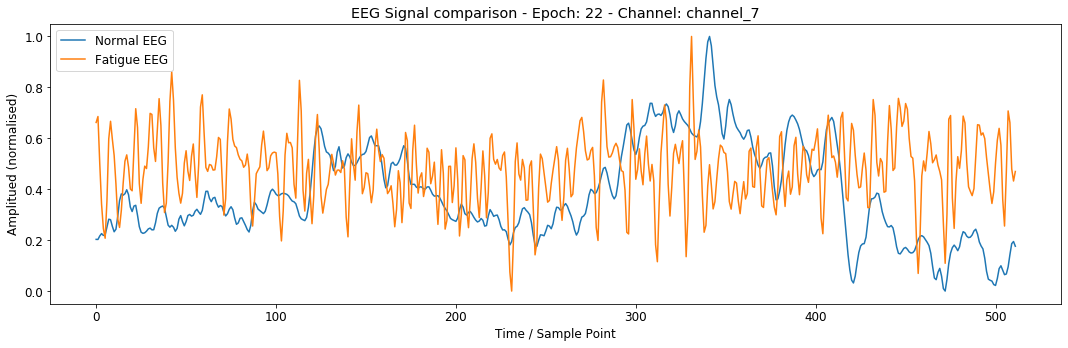

In [4]:
def plotWindowFromSeries(epochSeriesNormal, epochSeriesFatigue, window, channel, save_figure=False):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.set_title('EEG Signal comparison - Epoch: {} - Channel: {}'.format(window, channel))
    ax.plot(epochSeriesNormal[window][channel], label="Normal EEG")
    ax.plot(epochSeriesFatigue[window][channel], label="Fatigue EEG")
    plt.legend(loc="upper left")
    ax.set(xlabel='Time / Sample Point', ylabel='Amplitued (normalised)')
    
    if save_figure:
        save_fig("online_eeg_compare_epoch_{}_{}".format(window, channel))  # Not shown

plotWindowFromSeries(epochSeries_1_normal, epochSeries_1_fatigue, window=22, channel="channel_7", save_figure=True)

# Create Bandpass / Bandstop Filter

Saving figure bandpass_bandstop_filter


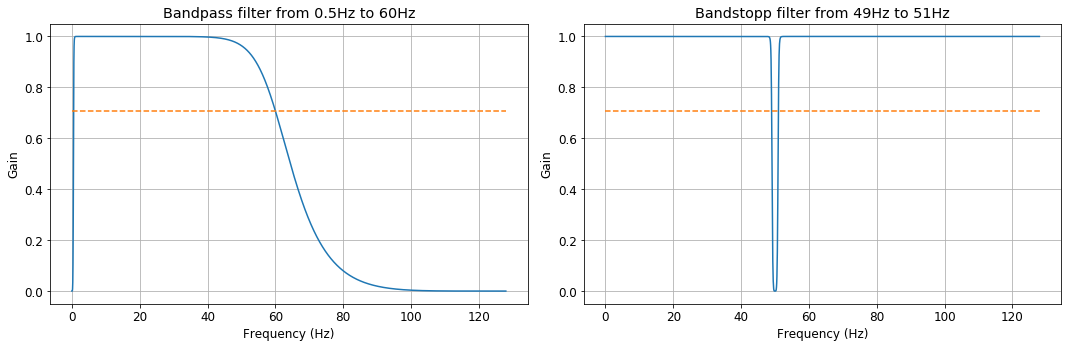

In [5]:
from filterFunctions import butter_bandpass
from scipy.signal import freqz

fs=256
order = 5

# Plot the frequency response for a few different orders.
fig, axs = plt.subplots(1, 2, figsize=(15,5))
b, a = butter_bandpass(lowcut=0.5, highcut=60, fs=fs, btype='band', order=order)
w, h = freqz(b, a, worN=2000)

axs[0].set_title('Bandpass filter from 0.5Hz to 60Hz')
axs[0].plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

axs[0].plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
axs[0].set(xlabel='Frequency (Hz)', ylabel='Gain')
axs[0].grid(True)

b, a = butter_bandpass(lowcut=49, highcut=51, fs=256, btype='stop', order=5)
w, h = freqz(b, a, worN=2000)

axs[1].set_title('Bandstopp filter from 49Hz to 51Hz')
axs[1].plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

axs[1].plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
axs[1].set(xlabel='Frequency (Hz)', ylabel='Gain')
axs[1].grid(True)
save_fig("bandpass_bandstop_filter")

# Plot Filtering / PSD and Magnitude Spectrum before and after Filtering

In [8]:
def plot_magnitudeFreq_and_PSD(data, samplingRate, signalName, figureName):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5)) # create 1 x 2 plot

    axes[0].set_title("Magnitude Spectrum - {}".format(signalName))
    axes[0].magnitude_spectrum(data, Fs=samplingRate, scale='dB', color='C1')

    axes[1].set_title("PSD - {}".format(signalName))
    axes[1].psd(data, Fs=samplingRate)

    fig.tight_layout()
    save_fig(figureName)
    plt.show()

Saving figure online_eeg_channel_7_spektrum


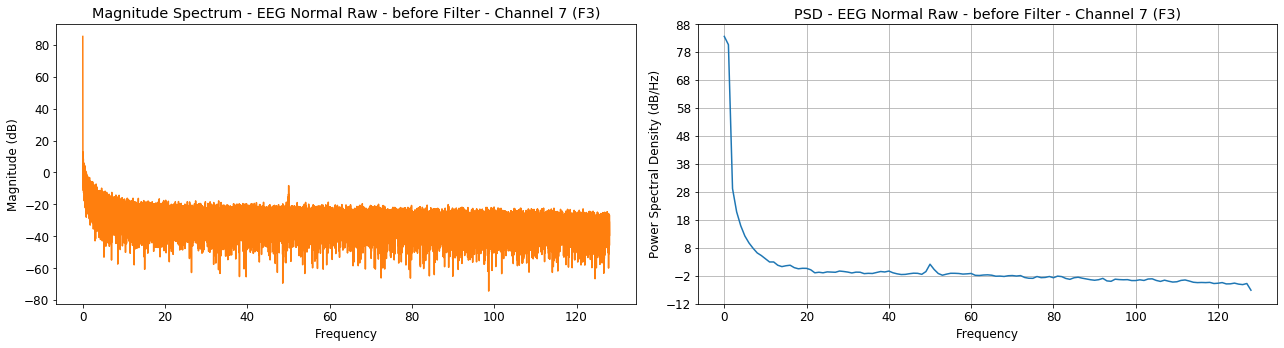

In [9]:
plot_magnitudeFreq_and_PSD(eeg_1_raw_normal['F3'], samplingRate=256, signalName="EEG Normal Raw - before Filter - Channel 7 (F3)",
                           figureName="online_eeg_channel_7_spektrum")

Saving figure online_eeg_channel_7_spektrum_after_bandpass


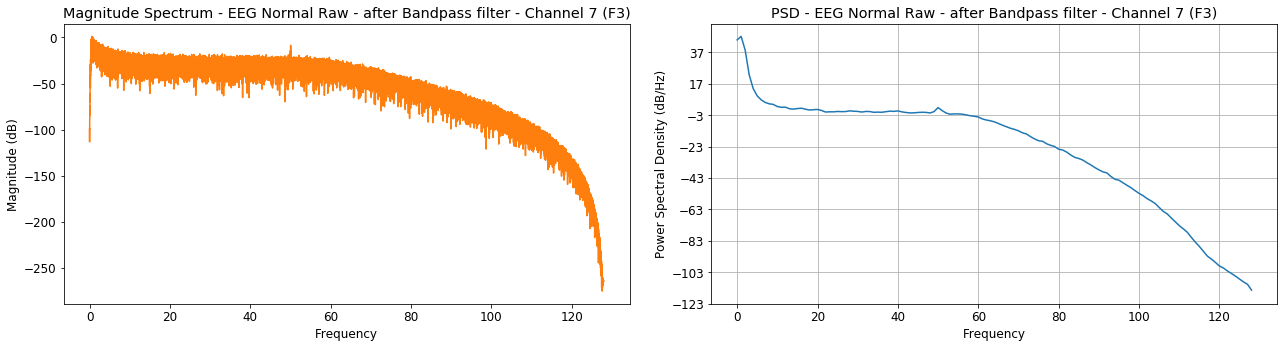

In [67]:
from filterFunctions import butter_bandpass_filter

eeg_1_raw_normal_filtered_ch7 = butter_bandpass_filter(data=eeg_1_raw_normal['F3'], lowcut=0.5, highcut=60, fs=256, btype='band', order=5)
plot_magnitudeFreq_and_PSD(eeg_1_raw_normal_filtered_ch7, samplingRate=256, signalName="EEG Normal Raw - after Bandpass filter - Channel 7 (F3)",
                           figureName="online_eeg_channel_7_spektrum_after_bandpass")

Saving figure online_eeg_channel_7_spektrum_after_bandpass_bandstop


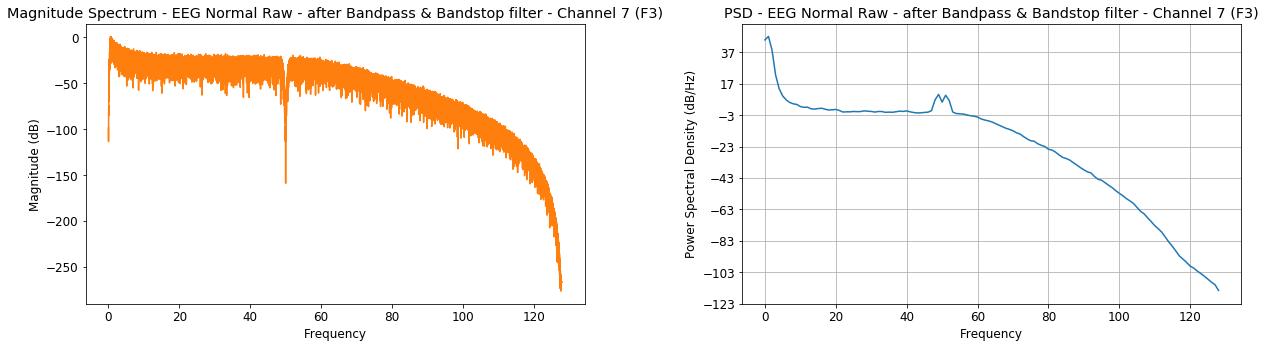

In [68]:
eeg_1_raw_normal_filtered_ch7 = butter_bandpass_filter(data=eeg_1_raw_normal_filtered_ch7, lowcut=49, highcut=51, fs=256, btype='bandstop', order=3)
plot_magnitudeFreq_and_PSD(eeg_1_raw_normal_filtered_ch7, samplingRate=256, signalName="EEG Normal Raw - after Bandpass & Bandstop filter - Channel 7 (F3)",
                          figureName="online_eeg_channel_7_spektrum_after_bandpass_bandstop")

# Show outlier detection

In [46]:
def filter_signal_no_outliers(df : pd.DataFrame, config : Dict) -> pd.DataFrame:
    ''' !Dummy function for showing purposes!
    Filter the signal with bandpass, bandstopp and repace outliers '''

    # signal processing pipeline - e.g. extract the signal from the raw .csv and filter it
    signal_processing_pipeline = Pipeline([
        ('Bandpass Filter', BandpassFilter(device=config['deviceName'], lowcufreq=config['lowcutFreq_bandpass'], highcutfreq=config['highcutFreq_bandpass'], samplingRate=config['samplingRate'])),
        ('Bandstop Filter', BandstopFilter(device=config['deviceName'], lowcufreq=config['lowcutFreq_bandstopp'], highcutfreq=config['highcutFreq_bandstopp'], samplingRate=config['samplingRate'])),
        #('Replace Outliers', ReplaceOutliers(device=config['deviceName'], lowerThreshold=config['lowerThreshold'], upperThreshold=config['upperThreshold']))
    ])
    df = signal_processing_pipeline.fit_transform(df)
    return df

SUBJECT = 1 # Subject to use
# Load the yaml config
yamlConfig = loadConfigFile(subjectDict[SUBJECT]["Device"])
df, featureList = convert_data(df=eeg_1_raw_normal.copy(), config=yamlConfig)

# Filter Signal - with outlier removal
df_no_outliers = filter_signal(df=df.copy(), config=yamlConfig)

# Filter Signal - no outlier removal
df_with_outliers = filter_signal_no_outliers(df=df.copy(), config=yamlConfig)

Loading the config file for neuroscan


Saving figure online_eeg_channel_7_outlier_removal


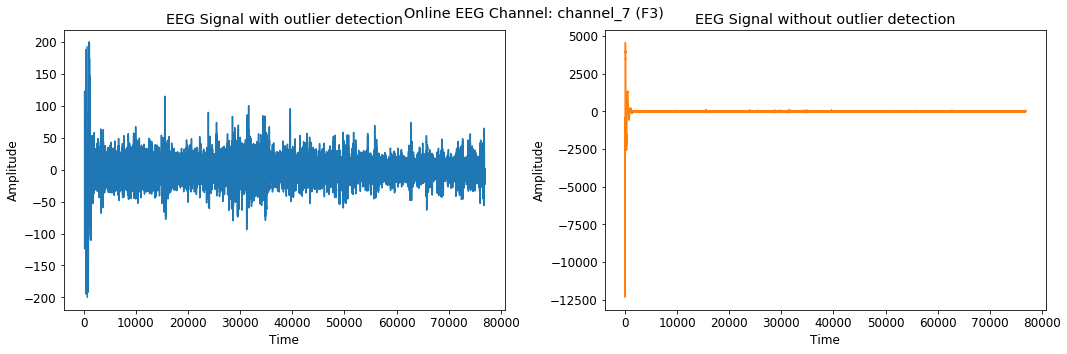

In [63]:
channel = "channel_7"

fig, axs = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Online EEG Channel: {} (F3)'.format(channel))

axs[0].plot(df_no_outliers.index, df_no_outliers[channel])
axs[0].set_title("EEG Signal with outlier detection")
axs[0].set(xlabel='Time', ylabel='Amplitude')

axs[1].plot(df_no_outliers.index, df_with_outliers[channel], 'tab:orange')
axs[1].set_title("EEG Signal without outlier detection")
axs[1].set(xlabel='Time', ylabel='Amplitude')
save_fig("online_eeg_{}_outlier_removal".format(channel))